# Tarea 01: Que hora es?

## Enunciado

El objetivo de esta tarea es realizar de manera individual un programa que determine automáticamente la hora que indica un reloj analógico:

### Alumno: Cristian Nova Santoya

# Desarrollo:

Para dar un mejor entendimiento del código final iré explicando paso a paso las funciones y razonamientos utilizados para calcular la hora.
Lo primero es cargar la imagen dada y ver su dimensiones:

4032 3024


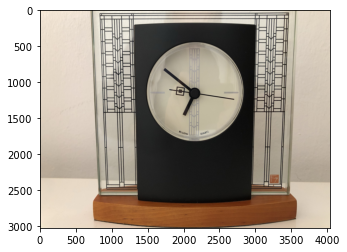

In [188]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io

im = Image.open("IMG_01.jpg")
x, y = im.size[0], im.size[1]
print(x,y)
plt.imshow(im)

De este primer vistazo obtenemos 2 datos relevantes: el primero es que las zonas de la imagen que contienen la información más importante se encuentran principalmente en tonos de alta y baja intensidad(blanco y negro) y el segundo que la resolución de la imagen es necesariamente alta.

Que la resolución sea tan alta es perjudicial al largo plazo, ya que mientras mayor sea el número de transformaciones o "escaneo" que le hagamos a la imagen mayor sera el tiempo de procesamiento. Por lo mencionado anteriormente el primer paso sera simplificar la imagen, esto lo lograremos disminuyendo la resolución y cambiando la imagen a tono de grises:

In [11]:
def escala_de_grises_y_disminuir_resolucion(im):
    #Obtenemos sus dimensiones
    x, y = im.size[0], im.size[1]
    
    #Creamos una nueva imagen con la mitad de la resolución de la imagen anterior
    im2 = Image.new('RGB', (int(x/2), int(y/2)))
    
    j = 0
    h = 0
    while j < y - 2:
        i = 0
        v = 0
        while i < x - 2:
            #Obtenemos el valor RGB de cada pixel
            r0, g0, b0 = im.getpixel((i,j))
            r1, g1, b1 = im.getpixel((i+1,j))
            r2, g2, b2 = im.getpixel((i,j+1))
            r3, g3, b3 = im.getpixel((i+1,j+1))
            # promediamos el tono de cada pigmento
            r = (r0 + r1 + r2 + r3)/4
            g = (g0 + g1 + g2 + g3)/4
            b = (b0 + b1 + b2 + b3)/4
            #Obtenemos su equivalente en la escala de gris
            p = (r * 0.3 + g * 0.59 + b * 0.11)
            #Ese valor lo convertimos a entero
            gris = int(p)
            pixel = tuple([gris, gris, gris])
            #En la nueva imagen en la posición v, h agregamos el nuevo pixel
            im2.putpixel((v,h), pixel)
            
            v += 1
            i += 2
        
        h += 1
        j += 2
        
    return im2

Probaremos el código y usaremos time de la librería time para medir el tiempo que toma en realizar esta operación.

16.885236024856567


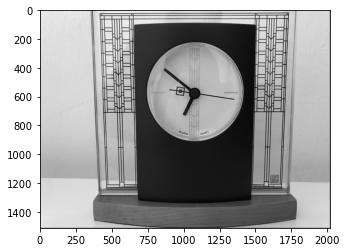

In [189]:
import time
start = time.time()
im = escala_de_grises_y_disminuir_resolucion(im)
end = time.time()
print(end - start)
plt.imshow(im)

Como se puede ver la imagen se simplifica y su calidad no disminuye lo suficiente como para ser critico. Solo hay un problema, al código le toma más de 15 segundos en solo completar esta tarea por lo que no es eficiente.

Para solucionarlo busque funciones en internet y cree el siguiente código:

In [160]:
def escala_de_grises_y_disminuir_resolucion2(ruta):
    im = Image.open(ruta)
    x, y = im.size[0]//2, im.size[1]//2

    im.thumbnail((x, y), Image.ANTIALIAS)
    im.save(f"new_{ruta}")
    im.close()

    im = io.imread(f"new_{ruta}")
    fun_gris = lambda rgb : np.dot(rgb[...,:3],[0.299,0.587,0.114])
    gris = fun_gris(im)
    
    return gris

### Fuentes:
* https://matplotlib.org/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py
* https://www.kdnuggets.com/2018/09/image-data-analysis-python-p3.html

0.6602180004119873


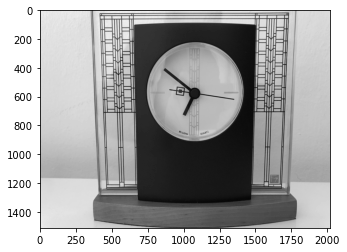

In [254]:
start = time.time()
im = escala_de_grises_y_disminuir_resolucion2("IMG_01.jpg")
end = time.time()
print(end - start)
plt.rcParams['image.cmap'] = 'gray'
plt.imshow(im, vmin = 0, vmax = 255)

El paso siguiente es encontrar el reloj dentro de la imagen, convenientemente el reloj es de color negro(aún más que las lineas de color negro que se encuentran en el cristal), por lo que debemos crear un código que encuentre la linea horizontal más larga compuesta por pixeles de baja intensidad, anotar la poción de los pixeles iniciales y finales, recortar y luego hacer lo mismo verticalmente.

Para determinar que pixeles son lo suficientemente oscuros para ser tomados en cuenta usaremos un umbral por debajo de 30 en una escala del 0 al 255:

In [45]:
def encontrar_reloj(im, margen):
    x, y = im.shape[1], im.shape[0]

    inicio = False
    punto_de_partida, punto_final  = 0, 0
    mas_largo = 0
    
    j = 0
    while j < y:
        i = 0
        while i < x :
            tono = im[j][i]
            
            if tono < margen:
                if not inicio:
                    punto_de_partida = i
                    inicio = True

            else:
                if inicio:
                    punto_final = i
                    longitud = punto_final - punto_de_partida

                    if longitud > mas_largo:
                        mas_largo = longitud
                        bordes_x = [punto_de_partida, punto_final]

                    inicio = False
            i += 1
        j += 1

    x = bordes_x[1]

    inicio = False
    punto_de_partida, punto_final  = 0, 0
    mas_largo = 0
    
    i = bordes_x[0]
    
    while i < x:
        j = 0
        while j < y :
            tono = im[j][i]
            
            if tono < margen:
                if not inicio:
                    punto_de_partida = j
                    inicio = True

            else:
                if inicio:
                    punto_final = j
                    longitud = punto_final - punto_de_partida

                    if longitud > mas_largo:
                        mas_largo = longitud
                        bordes_y = [punto_de_partida, punto_final]

                    inicio = False
            j += 1
        i += 1
    
    im = im[bordes_y[0]:bordes_y[1], bordes_x[0]:bordes_x[1]]

    return im

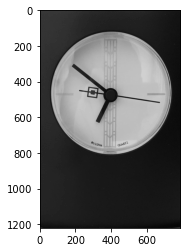

In [255]:
reloj_im = encontrar_reloj(im, 30)
plt.imshow(reloj_im)

De aquí en adelante me centre en como estudiar la imagen desde sus proporciones, para esto cree una código que segmenta la imagen en cuadrantes y la use para segmentar la imagen en cuadrantes de 6X8:

In [242]:
def dividir_en_hectarea(im, div_vert, div_hor):
    ancho, alto = im.shape[1], im.shape[0]
    # aquí establesco el largob de cada sub-cuadrante
    x, y = ancho// div_vert,  alto//div_hor
    num_x, num_y = 1, 1
    pixel = np.array([255])
    # esta parte remplaza traza las lineas reemplazando los pixeles por 0
    while num_x < div_vert:
        pos_x = num_x*x
        for j in range(alto):
            for k in range(-1,2):
                im[j][pos_x + k] = pixel 
        num_x += 1

    while num_y < div_hor:
        pos_y = num_y*y
        for i in range(ancho):
            for k in range(-1,2):
                im[pos_y + k][i] = pixel 
        num_y += 1

    return im

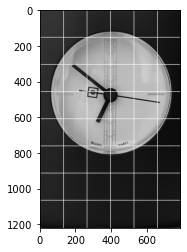

In [256]:
reloj_im = dividir_en_hectarea(reloj_im, 6, 8)
plt.imshow(reloj_im)

Tras un par de pruebas note que sin importar el tamaño del reloj en la foto, las proporciones de este se mantiene relativamente iguales por lo que podemos usar esto para encontrar la zona de las manecillas del reloj.

Antes de llegar al cálculo de los angulos debemos encontrar el centro de la circunferencia, para esto es conveniente simplificar un poco más la imagen.

Al probar el código en todas las imágenes de reloj comprobé que los bordes de las circunferencias siempre se encuentran entre los cuadrantes: (0, 2), (0, 3), (2,0), (3,0), (5,2), (5,3), (2,5), (2,5), (3,5), (3,6).
Se aprecia mejor con el siguiente código:

In [67]:
def pintar_cuadrante(im, div, lista_cuadrantes):
    div_ver, div_hor = div[0], div[1]

    x, y = im.shape[1], im.shape[0]

    bordes_x, bordes_y =   x//div_ver,  y//div_hor
    pixel = np.array([255])

    for cuadrante in lista_cuadrantes:
        lim_x_max, lim_x_min = bordes_x*(cuadrante[0] + 1),bordes_x*cuadrante[0]
        lim_y_max, lim_y_min = bordes_y*(cuadrante[1]+ 1) , bordes_y*cuadrante[1]
        
        for j in range(lim_y_min, lim_y_max):
            for i in range(lim_x_min, lim_x_max):
                im[j][i] = pixel
    return im

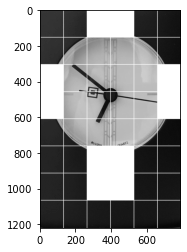

In [68]:
cuadrantes = [[2,0], [3,0], [0,2], [0,3], [5,2], [5,3],[2,6], [3,6], [2,5], [3,5]]
im_pintado = pintar_cuadrante(reloj_seg, [6,8], cuadrantes)
plt.imshow(im_pintado)

Con este dato podemos encontrar los bordes horizontales y verticales de la circunferencia del reloj, tomando en cuenta el contraste entre los tonos de blanco y negro, en áreas reducidas para luego recortar la imagen(de esta forma el encontrar los bordes y recortar es mucho más rápido):

(usaremos un delta-umbral entre tonos de 50)

In [257]:
def cortar_bordes_extra(im, diferencia):
    x, y = im.shape[1], im.shape[0]
    borde_x, borde_y = x//6, y//8
    # si la diferencia entre el tono anterior y el actual es mayor 
    # a la difencia entonces pasa a ser considerado el borde si es
    # que esta en un extremo
    color_anterior = im[borde_y*2][12]
    delta_x_min = 2000
    for j in range(borde_y*2, borde_y*4):
        for i in range(12, borde_x*2):
            if abs(color_anterior - im[j][i]) > diferencia and i < delta_x_min:
                delta_x_min = i
            color_anterior = im[j][i]
        color_anterior = im[j + 1][12]
    
    color_anterior = im[borde_y*2][borde_x*5]
    delta_x_max = 0
    for j in range(borde_y*2, borde_y*4):
        for i in range(borde_x*5, borde_x*6 - 12):
            
            if abs(color_anterior - im[j][i]) > diferencia and i > delta_x_max:
                delta_x_max = i
            color_anterior = im[j][i]
        color_anterior = im[j + 1][borde_x*5]
    
    
    color_anterior = im[12][borde_x*2]
    delta_y_min = 2000
    for i in range(borde_x*2, borde_x*4):
        for j in range(12, borde_y):
            if abs(color_anterior - im[j][i]) > diferencia and j < delta_y_min:
                delta_y_min = j
            color_anterior = im[j][i]
        color_anterior = im[12][i + 1]
                   
    color_anterior = im[borde_y*5][borde_x*2]
    delta_y_max = 0
    for i in range(borde_x*2, borde_x*4):
        for j in range(borde_y*5, borde_y*7):
            if abs(color_anterior - im[j][i]) > diferencia and j > delta_y_max:
                delta_y_max = j
            color_anterior = im[j][i]
        color_anterior = im[borde_y*5][i + 1]
            
    im = im[delta_y_min:delta_y_max, delta_x_min:delta_x_max]

    return im

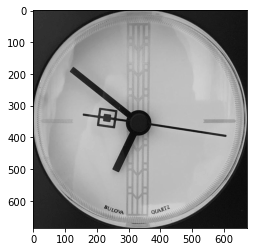

In [236]:
reloj_im = cortar_bordes_extra(reloj_im, 50)
plt.imshow(reloj_im)

Bajo el supuesto de que la imagen se encuentra relativamente recta solo nos queda determinar la hora a partir del ángulo de las manecillas, para esto primero hay que encontrar el centro del circulo. Para esto probaremos segmentado la imagen en cuadrantes de 9X9 y de 11X11:

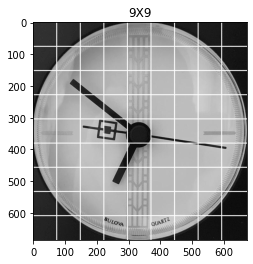

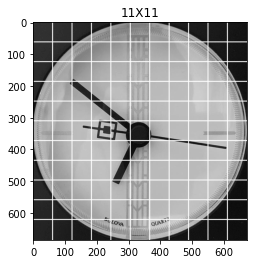

In [258]:
def mostrat_div(div_ver, div_hor):
    im = escala_de_grises_y_disminuir_resolucion2("IMG_01.jpg")
    reloj_im = encontrar_reloj(im, 30)
    reloj_im = cortar_bordes_extra(reloj_im, 60)
    reloj_seg = dividir_en_hectarea(reloj_im, div_ver, div_hor)
    plt.figure()
    plt.title(f"{div_ver}X{div_hor}")
    plt.imshow(reloj_seg)
mostrat_div(9, 9)
mostrat_div(11, 11)


Como todos los relojes comparten las mismas proporciones entonces, para el caso de la segmentación de 11X11, todos deben tener su centro dentro del cuadrante (5,5) y pareciera ser que el diámetro de la circunferencia mas chica es la novena parte del diámetro de la circunferencia total.

Antes de crear el código que busque el centro es preferible borrar todos lo pixeles de la imagen que hacen ruido, para esto cree un código que segrega los tonos dependiendo de su intensidad:

In [ ]:
def segregador_de_tonos(im, minimo, maximo):
    dimenciones = im.shape
    x, y = dimenciones[0], dimenciones[1]
    pixel0 = 0
    pixel1 = 255

    j = 0
    while j < y:
        i = 0
        while i < x :
            tono = im[i][j]
        
            if minimo < tono < maximo:
                im[i][j] = pixel1

            else:
                im[i][j] = pixel0
            i += 1
        j += 1

    return im   

En esta prueba pasaremos todos los pixeles con tonos entre 80 y 255 a 255.

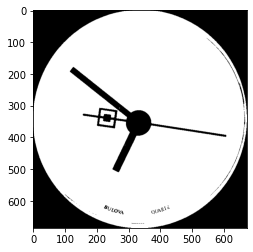

In [290]:
im = escala_de_grises_y_disminuir_resolucion2("IMG_01.jpg")
reloj_im = encontrar_reloj(im, 30)
reloj_im = cortar_bordes_extra(reloj_im, 60)
reloj_w_b = segregador_de_tonos(reloj_im, 80, 255)
plt.imshow(reloj_w_b)

El centro del circulo siempre es negro así que podemos determinar el centro a través de este dato.

adicionalmente se creo un código que dibuja una circunferencia para comprobar que el centro este bien determinado:

In [285]:
def encontrar_centro(im):
    # este codigo revisa el cudrante (5,5) en un subdivicion de 11X11
    
    # se establese el radio maximo correspondiente a las 
    # dimenciones vistas en la segmentación de 9X9
    radio_maximo = im.shape[1]//18
    x, y = im.shape[1]//11, im.shape[0]//11
    num_centros = 0
    centro_x = 0
    centro_y = 0
    
    # En principio el código funciona así: 
    # por cada píxel  en el cuadrante se revisan los pixeles al rededor,
    #en un margen correspondiente al radio de la circunferencia,
    # para asegurarse que todos sean de intensidad 0, si es así
    # entonces se suman las coordenadas i y j de los centro a centro_x y centro_y 
    # respectivamente para finalmente obtener un centro promedio 
    # al dividir centro_x y centro_y por la cantidad de centros.
    # Se aumento la magnitud de los contadores para no tener que revisar
    # cada centro, también se agregaron restricciones para acelerar el proceso
    
    i = x*5
    while x*5 <= i <= x*6:
        j = y*5
        while y*5 <= j <= y*6:
            
            seguir = True 
            pos_x = i  - radio_maximo
            while i - radio_maximo <= pos_x <= i + radio_maximo and seguir:
                
                pos_y =  j - radio_maximo
                while  j - radio_maximo <= pos_y <= j + radio_maximo and seguir:
                    radio = delta_x = ((pos_y - j)**2 + (pos_x - i)**2)**(1/2)
                    color = im[pos_y][pos_x]
                    
                    if radio <= radio_maximo and color == 255:
                        seguir = False
                        
                    pos_y += 2
                
                pos_x += 2
            
            if seguir == True:
                num_centros += 1
                centro_x += i
                centro_y += j
                centro = [i,j]
                i += 3
                j += 2
            
            j += 2
        
        i += 2

    centro_x = centro_x//num_centros
    centro_y = centro_y//num_centros
    return centro_x, centro_y

se creo un código extra para dibujar círculos en la imagen y comprobar que el centro estuviera efectivamente en la posición obtenida, después de un par de pruebas se comprobó que la manecilla mas corta tenia un radio muy cercano a la cuarta parte del diámetro de la circunferencia total.

In [283]:
def poner_un_anillo(pos_x, pos_y, radio, ancho, color, im):
    x, y = im.shape[1], im.shape[0]
    for fila in range(x):
        for columna in range(y):
            delta_x = (abs(columna - pos_y))**2
            delta_y = (abs(fila - pos_x))**2
            hip = (delta_x + delta_y)**(1/2)

            if (radio - ancho/2) <= hip <= (radio + ancho/2):
                im[columna][fila]= np.array([color])

    return im

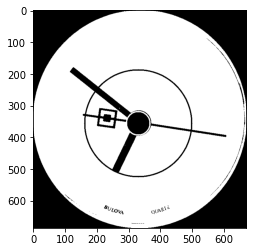

In [287]:
im = escala_de_grises_y_disminuir_resolucion2("IMG_01.jpg")
im = encontrar_reloj(im, 30)
im = cortar_bordes_extra(im, 50)
im = segregador_de_tonos(im, 80, 255)
centro_x, centro_y = encontrar_centro(im)
im = poner_un_anillo(centro_x, centro_y, im.shape[1]//18, 4, 255, im)
im = poner_un_anillo(centro_x, centro_y, im.shape[1]//4 , 4, 0, im)
plt.imshow(im)
plt.show()

Lo ultimo es encontrar las manecillas, determinar el ángulo y obtener la hora y minutos. se me ocurrió que si recorría la circunferencia con un radio un poco menor al largo del radio de la manecilla mas chica y solo tomaba encuesta las dos más anchas, diferenciado una de la otra, y anotaba los ángulos en que se encontraban, entonces tendría los ángulos de ambas manecillas.

Al recorrer la circunferencia partiendo desde la horizontal en sentido horario se podría decir que la hora estaría 90 grados atrasada por lo que habrá que sumarle 90 grados para tenerla ajustada, luego solo faltaría aplicar regla de tres al horario y minutero  para saber la hora y los minutos:

Con aplicar regla de tres me refiero a que:
hora =  (12 * alngulo_horario)//360
minutos = (60 * alngulo_minutero)//360

In [275]:
def encontrar_manecillas(im, centro_y, centro_x):
    radio = im.shape[1]//4 - 10
    angulo = 0

    lista_angulos = []
    lista_largos = []
    en_manesilla = False
    
    while angulo <= 360:
        rad_ang = (np.pi*angulo)/180
        i = int(radio*np.cos(rad_ang)) + centro_x
        j = int(radio*np.sin(rad_ang)) + centro_y
        if im[j][i] == 0 and not en_manesilla:
            primer_ang = angulo
            en_manesilla = True

        elif im[j][i] == 255 and en_manesilla:
            ultimo_ang = angulo
            delta = ultimo_ang  - primer_ang
            pro = (ultimo_ang  + primer_ang)/2
            lista_angulos.append(pro)
            lista_largos.append(delta)
            en_manesilla = False

        angulo += 1
        
    max_position = lista_largos.index(max(lista_largos))
    lista_largos.pop(max_position)
    alngulo_horario = lista_angulos.pop(max_position)
    max_position = lista_largos.index(max(lista_largos))
    alngulo_minutero = lista_angulos.pop(max_position)
    
    alngulo_horario = alngulo_horario + 90
    alngulo_minutero = alngulo_minutero + 90
        
    hora = (12*alngulo_horario)//360
    minutos = (60*alngulo_minutero)//360
    
    if hora >= 12:
        hora -= 12
    if minutos >= 60:
        minutos -= 60
    
    print(f"hora: {int(hora)}, min: {int(minutos)}")

ya con todo esto pasamos a crear el codigo final

In [276]:
def leer_la_hora(ruta):
    im = escala_de_grises_y_disminuir_resolucion2(ruta)
    im = encontrar_reloj(im, 30)
    im = cortar_bordes_extra(im, 50)
    im = segregador_de_tonos(im, 80, 255)
    centro_x, centro_y = encontrar_centro(im)
    encontrar_manecillas(im, centro_y, centro_x)

In [288]:
leer_la_hora("IMG_01.jpg")

hora: 6, min:51


### Veamos que hora marcan todos los relojes:

In [289]:
for i in range(1,7):
    print(f"En el reloj {i} marca")
    leer_la_hora(f"IMG_0{i}.jpg")
    print()

En el reloj 1 marca
hora: 6, min:51

En el reloj 2 marca
hora: 4, min:9

En el reloj 3 marca
hora: 2, min:30

En el reloj 4 marca
hora: 0, min:41

En el reloj 5 marca
hora: 11, min:15

En el reloj 6 marca
hora: 10, min:8

